# Final Project Submission

Please fill out:

* Student name: Carrie Liu
* Student pace: self paced
* Scheduled project review date/time: April 1, 2022 / 2:30 PM EST
* Instructor name: Abhineet Kulkarni
* Blog post URL:


## Overview

Our client, Andersen Investco is a boutique real-estate investment firm based in New York City. They want to have a better understanding of the trends in housing market, and to look for advice on what are the top 5 zipcodes in the state of New York.

Our team is hired to perform a time series analysis using Zillow’s historical housing data for the United States. The aim was to provide investors with the best zip codes to buy and develop homes in the state of Texas.

#### Our Approach
We will forcast the home values of various zip codes using the data from [Zillow Research](https://www.zillow.com/research/data/) based on time series modeling. 

* Datasets: A smoothed, seasonally adjusted measure of the typical home value and makret changes across a given region and housing type. It reflects the typical value for homes in the 35th to 65th percentile range.
* Review period: January 2000 - February 2022

## Step 1: Load the Data

### Import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
import itertools

### Load the data

In [3]:
df_raw = pd.read_csv('zipcode_zillow_data.csv')

In [4]:
df_raw = df_raw.drop(['RegionID', 'RegionType', 'StateName'], axis = 1)

## Step 2: EDA - Zipcode Selection

The real-estate company will have the following preferences:

* State: As the pandemic is improving, more people will come to New York because of the robust job markets. The local residents, who are the customers/investors of our client, will also consider moving to surburb or nearby cities for schools. Therefore, our client wants to invest specifically in the state of New York. 


* Typical home value: The zipcode’s average housing price should be between 1 deciles below and 1 decile above the zipcode’s 1-year median home value. A one-year parameter was chosen because it is most realistic about the prices a real estate investor will face shortly. Zillow Home Value Index (ZHVI) has already reflects the typical value for homes in the 35th to 65th percentile range. (https://www.zillow.com/research/data/)


* Urbanization: The column 'SizeRank' stands for the zipcode ranking by urbanization. The higher the rank, the more urbanization the area. Zipcode should be in the top 25% according to the SizeRank variable.


* Total growth rate: we will select the zipcodes with the highest total growth rate over the review period (pre-pandemic). 


* Diversification: It is a common investment strategy through which investors spread their portfolio across different types of asset classes to reduce the risk of market volatility. Therefore, zip codes were chosen should be in different county, and a coefficient of variation below the 75 percentile.

### State - New York

In [5]:
df_ny = df_raw[df_raw['State'] == 'NY']

In [6]:
df_ny = df_ny.drop(['State', 'Metro'], axis=1)

In [7]:
print(df_ny.shape)
df_ny.head()

(1747, 270)


,SizeRank,RegionName,City,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,...,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28
0,0,10025,New York,New York County,324065.0,328927.0,332826.0,341332.0,349011.0,356357.0,...,1099099.0,1103230.0,1111925.0,1120772.0,1131113.0,1135498.0,1134880.0,1135449.0,1141334.0,1153073.0
2,2,10023,New York,New York County,499335.0,503175.0,505873.0,512543.0,520465.0,531186.0,...,1446279.0,1444636.0,1446466.0,1460694.0,1476283.0,1484817.0,1489017.0,1489327.0,1499790.0,1509400.0
6,6,10002,New York,New York County,412971.0,407553.0,407764.0,405869.0,410926.0,413856.0,...,829371.0,859999.0,879073.0,907959.0,917323.0,920516.0,926162.0,929329.0,934496.0,934354.0
10,10,11226,New York,Kings County,267429.0,269408.0,270754.0,273313.0,275830.0,278509.0,...,788499.0,789382.0,794372.0,805171.0,821011.0,830444.0,832748.0,828658.0,829321.0,831452.0
11,11,10467,New York,Bronx County,144395.0,145633.0,146629.0,148969.0,151173.0,153425.0,...,442727.0,434665.0,428665.0,430256.0,434499.0,437859.0,440266.0,440443.0,440880.0,443240.0


### Urbanization

In [8]:
sr_25 = df_ny['SizeRank'].quantile(q=0.25)

In [9]:
df_ny_urban = df_ny[df_ny['SizeRank'] < sr_25]

In [10]:
df_ny_urban.head()

,SizeRank,RegionName,City,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,...,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28
0,0,10025,New York,New York County,324065.0,328927.0,332826.0,341332.0,349011.0,356357.0,...,1099099.0,1103230.0,1111925.0,1120772.0,1131113.0,1135498.0,1134880.0,1135449.0,1141334.0,1153073.0
2,2,10023,New York,New York County,499335.0,503175.0,505873.0,512543.0,520465.0,531186.0,...,1446279.0,1444636.0,1446466.0,1460694.0,1476283.0,1484817.0,1489017.0,1489327.0,1499790.0,1509400.0
6,6,10002,New York,New York County,412971.0,407553.0,407764.0,405869.0,410926.0,413856.0,...,829371.0,859999.0,879073.0,907959.0,917323.0,920516.0,926162.0,929329.0,934496.0,934354.0
10,10,11226,New York,Kings County,267429.0,269408.0,270754.0,273313.0,275830.0,278509.0,...,788499.0,789382.0,794372.0,805171.0,821011.0,830444.0,832748.0,828658.0,829321.0,831452.0
11,11,10467,New York,Bronx County,144395.0,145633.0,146629.0,148969.0,151173.0,153425.0,...,442727.0,434665.0,428665.0,430256.0,434499.0,437859.0,440266.0,440443.0,440880.0,443240.0


### Growth Rate

Across our review period, two time periods should be hightlightened: one is 2008 financial crisis, and the other is 2020 COVID-19 pandemics. It is important to take into account significant historical context when considering our data. Therefore, we will analyze the growth rate into the four timeframes: pre-financial crisis (01/2000 - 12/2007), financial crisis [(01/2008 - 07/2009)](https://www.federalreservehistory.org/essays/great-recession-of-200709), pre-pandemics (08/2009 - 02/2020), pandemics [(03/2020 - 02/2022)](https://www.yalemedicine.org/news/covid-timeline).

In [11]:
df_ny_urban['GR_1'] = (df_ny_urban['2007-12-31']/df_ny_urban['2000-01-31'])-1
df_ny_urban['GR_2'] = (df_ny_urban['2009-07-31']/df_ny_urban['2007-12-31'])-1
df_ny_urban['GR_3'] = (df_ny_urban['2020-02-29']/df_ny_urban['2009-07-31'])-1
df_ny_urban['GR_4'] = (df_ny_urban['2022-02-28']/df_ny_urban['2020-02-29'])-1

In [12]:
df_ny_urban[['GR_1', 'GR_2', 'GR_3', 'GR_4']]

,GR_1,GR_2,GR_3,GR_4
0,1.833722,-0.170841,0.386449,0.092259
2,1.571752,-0.197486,0.412503,0.036910
6,1.274673,-0.140375,0.291615,-0.104159
10,1.199746,-0.140295,0.576153,0.043057
11,1.243651,-0.175534,0.557225,0.065632
...,...,...,...,...
8462,0.981386,-0.173656,0.440078,0.114807
8464,0.710887,-0.067901,0.096598,0.388758
8465,1.256491,-0.111208,0.183539,0.312399
8488,0.838843,-0.058403,0.294229,0.334205


Considering that our client will invest in mid 2022, the situation will be similar to the post-financial crisis. Therefore, we will select pre-pandemics & post-financial crisis (08/2009 - 02/2020) as our benchmark to measure the growth rate.

### Diversification

In [13]:
#Calculate standard deviation of monthly values
df_ny_urban['std'] = df_ny_urban.loc[:,'2009-07-31':'2020-02-29'].std(skipna=True, axis=1)

#Calculate historical mean value
df_ny_urban['mean'] = df_ny_urban.loc[:,'2009-07-31':'2020-02-29'].mean(skipna=True, axis=1)

#Calculate coefficient of variance
df_ny_urban['CV'] = df_ny_urban['std']/df_ny_urban['mean']

#Show calculated values
df_ny_urban[['RegionName', 'City', 'CountyName','std','mean','GR_3','CV']].head()

,RegionName,City,CountyName,std,mean,GR_3,CV
0,10025,New York,New York County,142114.067360,8.929045e+05,0.386449,0.159159
2,10023,New York,New York County,199638.573890,1.225435e+06,0.412503,0.162912
6,10002,New York,New York County,93290.587925,8.797345e+05,0.291615,0.106044
10,11226,New York,Kings County,128701.015844,6.252404e+05,0.576153,0.205842
11,10467,New York,Bronx County,48671.399679,2.959556e+05,0.557225,0.164455


In [14]:
#Descriptive statistics of coefficients of variance.
print(df_ny_urban['CV'].describe())

count    437.000000
mean       0.113464
std        0.058800
min        0.025438
25%        0.067406
50%        0.105181
75%        0.147638
max        0.348045
Name: CV, dtype: float64


In [15]:
#Define upper limit of CV according to risk profile.
upper_cv = df_ny_urban['CV'].quantile(.75)
upper_cv

0.14763807316928754

In [16]:
#Get the zipcodes with highest ROIs within the risk profile.
df_ny_selected = df_ny_urban[df_ny_urban['CV'] < upper_cv].sort_values('GR_3',
                                                                       axis=0,
                                                                       ascending=False)

In [17]:
df_ny_selected

,SizeRank,RegionName,City,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,...,2021-12-31,2022-01-31,2022-02-28,GR_1,GR_2,GR_3,GR_4,std,mean,CV
19,20,11235,New York,Kings County,192402.0,193100.0,194621.0,197850.0,201434.0,204756.0,...,652647.0,654535.0,657244.0,1.308703,-0.103627,0.490409,0.107529,67602.661494,483547.929688,0.139806
4701,4746,14217,Tonawanda,Erie County,81266.0,81456.0,81960.0,82471.0,83003.0,82051.0,...,204540.0,205969.0,208290.0,0.266803,0.036339,0.484914,0.314763,16982.359861,122669.570312,0.138440
2031,2045,14225,Cheektowaga,Erie County,75625.0,76325.0,76703.0,77375.0,77942.0,78386.0,...,182897.0,184704.0,187053.0,0.226658,0.013378,0.480358,0.344119,14105.739347,104565.804688,0.134898
7168,7237,14611,Rochester,Monroe County,46701.0,45701.0,45712.0,45641.0,46614.0,47536.0,...,85148.0,85723.0,86399.0,0.022269,-0.112754,0.456041,0.400876,5296.099176,47127.562500,0.112378
4988,5037,14607,Rochester,Monroe County,98757.0,98439.0,98503.0,99068.0,99894.0,100747.0,...,259002.0,261752.0,265572.0,0.535203,-0.024213,0.455580,0.233268,21055.000200,171500.523438,0.122769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7477,7552,10960,Orangetown,Rockland County,309123.0,310373.0,311212.0,313984.0,317440.0,321024.0,...,617284.0,624121.0,629920.0,0.946031,-0.081863,-0.077104,0.235789,22707.947359,491197.679688,0.046230
129,130,10452,New York,Bronx County,221243.0,227165.0,230947.0,234006.0,234876.0,235128.0,...,399350.0,402767.0,406978.0,1.391696,-0.148798,-0.154497,0.068680,45536.068099,369294.593750,0.123306
7958,8040,12771,Port Jervis,Orange County,107526.0,108222.0,109725.0,111960.0,115433.0,116957.0,...,232876.0,236087.0,239720.0,1.193302,-0.097521,-0.194237,0.397809,16789.309510,160810.640625,0.104404
7967,8050,12701,Thompson,Sullivan County,78762.0,79543.0,80128.0,81150.0,81854.0,82703.0,...,197012.0,200436.0,204101.0,1.162502,-0.037670,-0.198631,0.553871,14242.455316,143214.601562,0.099448


In [18]:
#Get the zipcodes with highest ROIs in the top 10 Counties
df_ny_best = df_ny_selected.sort_values(['GR_3'],
                                        ascending=False).groupby('CountyName').head(1)[:5]

In [19]:
df_ny_best

,SizeRank,RegionName,City,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,...,2021-12-31,2022-01-31,2022-02-28,GR_1,GR_2,GR_3,GR_4,std,mean,CV
19,20,11235,New York,Kings County,192402.0,193100.0,194621.0,197850.0,201434.0,204756.0,...,652647.0,654535.0,657244.0,1.308703,-0.103627,0.490409,0.107529,67602.661494,483547.929688,0.139806
4701,4746,14217,Tonawanda,Erie County,81266.0,81456.0,81960.0,82471.0,83003.0,82051.0,...,204540.0,205969.0,208290.0,0.266803,0.036339,0.484914,0.314763,16982.359861,122669.570312,0.138440
7168,7237,14611,Rochester,Monroe County,46701.0,45701.0,45712.0,45641.0,46614.0,47536.0,...,85148.0,85723.0,86399.0,0.022269,-0.112754,0.456041,0.400876,5296.099176,47127.562500,0.112378
4775,4821,11414,New York,Queens County,350519.0,352835.0,355219.0,358986.0,362542.0,367171.0,...,768337.0,772495.0,775204.0,0.635455,-0.159220,0.440340,0.116653,71442.232498,534006.890625,0.133785
1302,1310,10475,New York,Bronx County,223154.0,224955.0,227189.0,230854.0,233106.0,233897.0,...,544843.0,548402.0,550939.0,0.835338,-0.136589,0.435650,0.085218,52056.286060,374372.164062,0.139050


In [20]:
df_ny_best = df_ny_best.drop(['GR_1','GR_2','GR_3','GR_4', 'std', 'mean', 'CV'], axis=1)

In [21]:
zipcodes = list(df_ny_best['RegionName'].unique())
for i in zipcodes:
    city = df_ny_best[df_ny_best['RegionName'] == i].City.values[0]
    county = df_ny_best[df_ny_best['RegionName'] == i].CountyName.values[0]
    print(f'Zipcode: {i} \n Location: {city}, {county} \n')

Zipcode: 11235 
 Location: New York, Kings County 

Zipcode: 14217 
 Location: Tonawanda, Erie County 

Zipcode: 14611 
 Location: Rochester, Monroe County 

Zipcode: 11414 
 Location: New York, Queens County 

Zipcode: 10475 
 Location: New York, Bronx County 



In [22]:
zipcodes

[11235, 14217, 14611, 11414, 10475]

## Step 3: Reshape Data from Wide to Long Format

In [23]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, 
                     id_vars=['RegionName',
                              'SizeRank',
                              'City', 
                              'CountyName'], 
                     var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], 
                                    infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted
    return melted.groupby('time').aggregate({'value':'mean'})

In [24]:
data_ny = pd.DataFrame()
for z in zipcodes:
    d = melt_data(df_ny_best[df_ny_best['RegionName']==z])
    data_ny = pd.concat([d,data_ny])
data_ny.head()

,RegionName,SizeRank,City,CountyName,time,value
0,10475,1310,New York,Bronx County,2000-01-31,223154.0
1,10475,1310,New York,Bronx County,2000-02-29,224955.0
2,10475,1310,New York,Bronx County,2000-03-31,227189.0
3,10475,1310,New York,Bronx County,2000-04-30,230854.0
4,10475,1310,New York,Bronx County,2000-05-31,233106.0


## Step 4: Time Series Modeling

### Visualize the time series data - Top 5 Zipcodes in NY

In [25]:
data_ny = data_ny.drop(['SizeRank', 'City', 'CountyName'], axis = 1)

In [26]:
data_ny.reset_index(inplace=True)

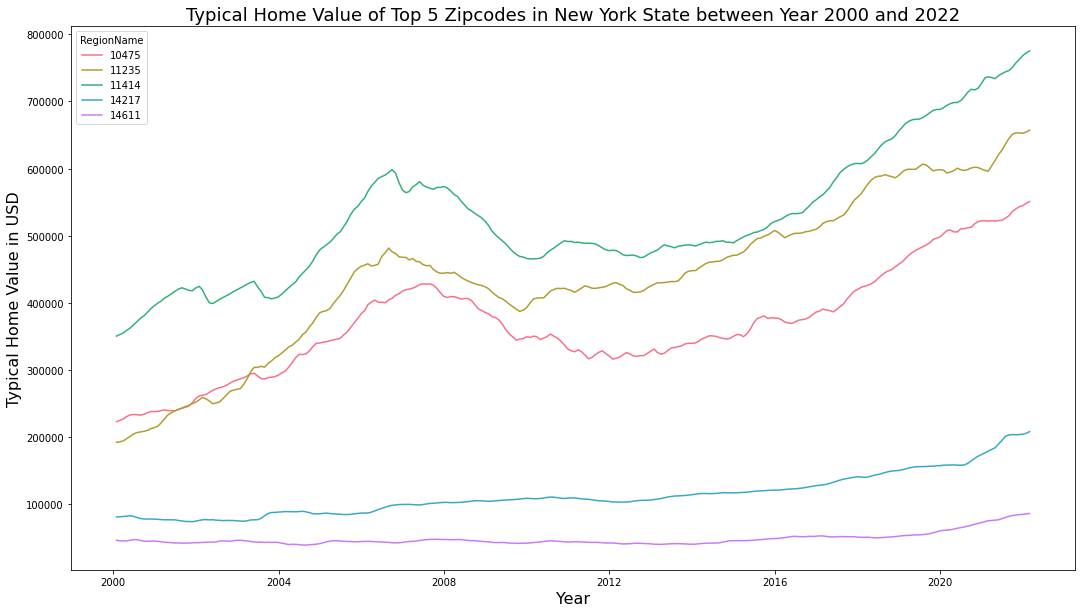

In [27]:
plt.figure(figsize = (18,10))
palette = sns.husl_palette(len(zipcodes))
sns.lineplot(x='time', y='value', hue='RegionName', palette = palette,
             data=data_ny[data_ny['RegionName'].isin(zipcodes)])
plt.title('Typical Home Value of Top 5 Zipcodes in New York State between Year 2000 and 2022',
          fontsize = 18)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Typical Home Value in USD', fontsize = 16);

The typical housing prices had a positive trend and the prices are probably not stationary because the next period prices depended on the previous period price.

The ultimate goal of investing is to achieve the high ROI. Therefore, we will focus on the monthly returns and build a model for the selected 5 zipcodes to forecast their monthly returns. 

In [28]:
dfs_ts = []
for zipcode in zipcodes:
    #Create separate dataframes for each zipcode with a monthly frequency.
    df = data_ny[data_ny['RegionName']==zipcode]
    dfs_ts.append(df)

In [29]:
for n in range(len(dfs_ts)):
    dfs_ts[n]['return'] = dfs_ts[n]['value'] / dfs_ts[n]['value'].shift() - 1

In [30]:
for n in range(len(dfs_ts)):
    dfs_ts[n].fillna(0, inplace=True)

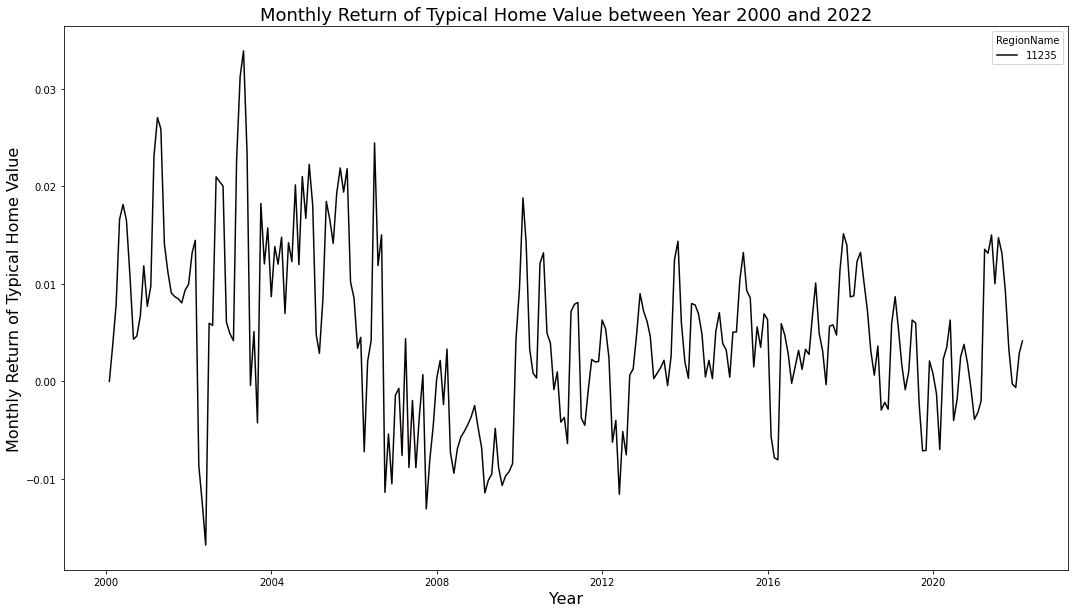

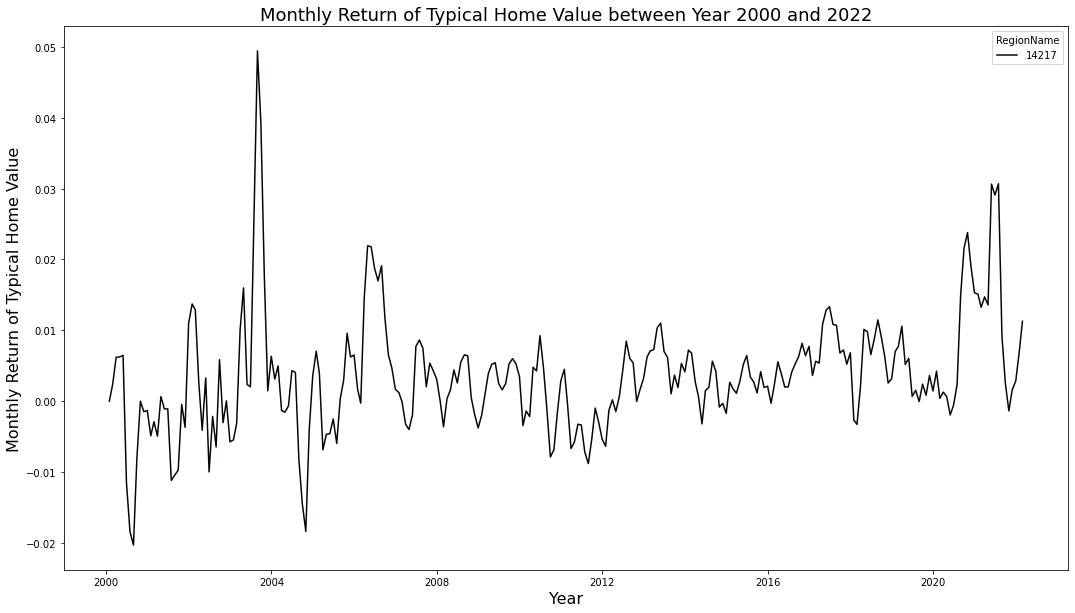

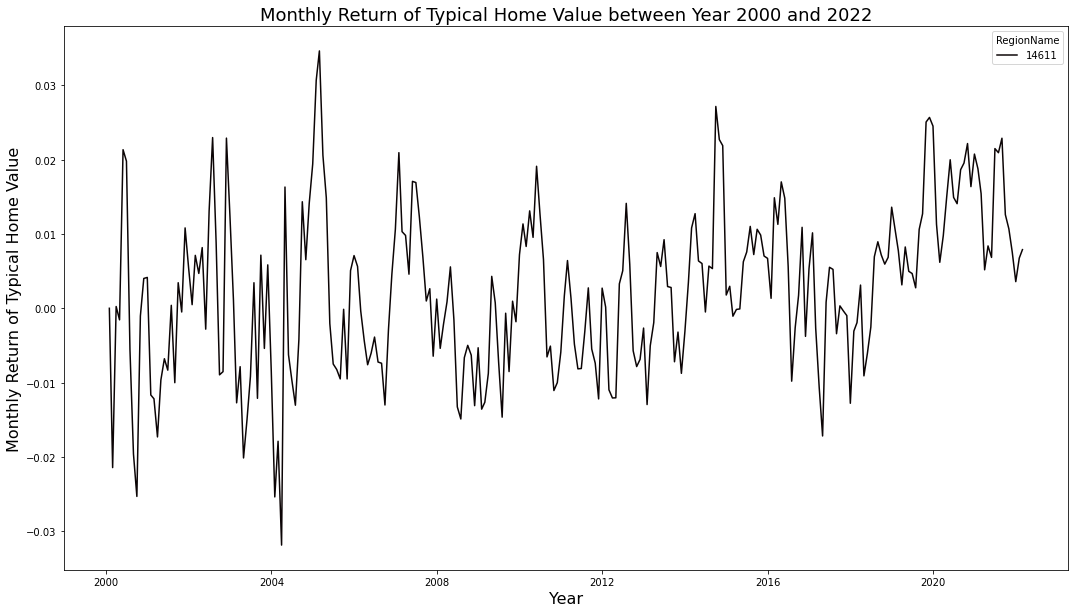

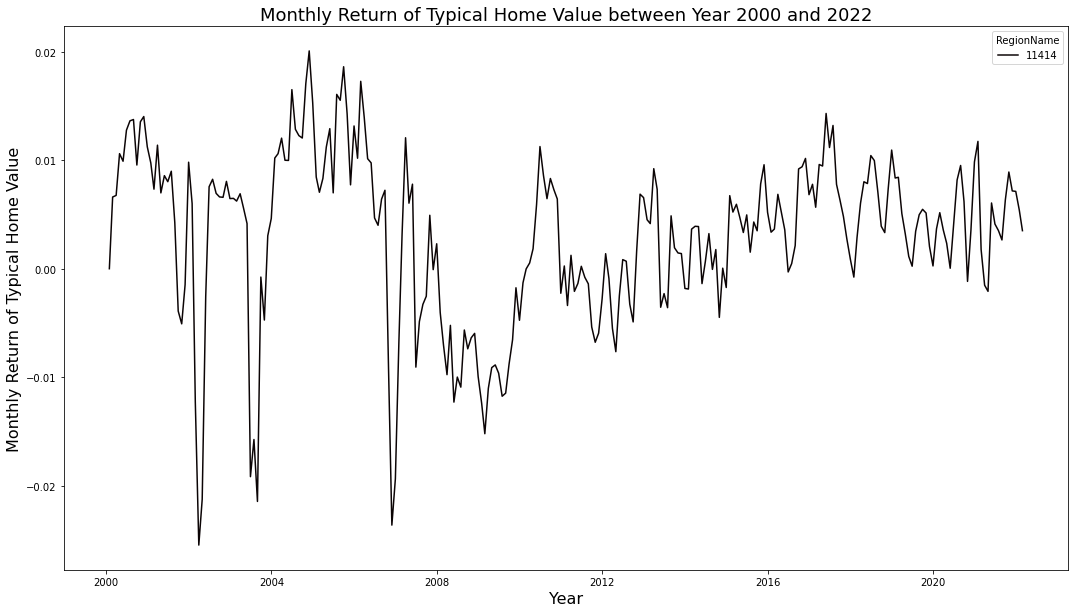

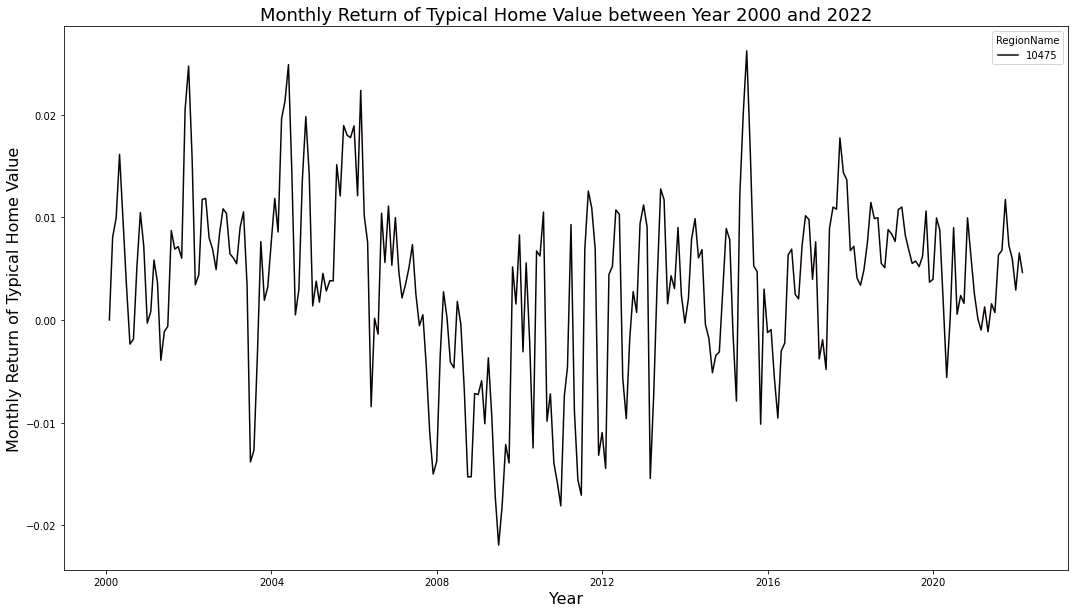

In [31]:
#Plot the monthly returns of each zipcode
for n in range(len(dfs_ts)):
    plt.figure(figsize = (18,10))
    df = dfs_ts[n]
    sns.lineplot(x='time', y='return', hue='RegionName', palette = 'mako', data=df)
    plt.title('Monthly Return of Typical Home Value between Year 2000 and 2022', fontsize = 18)
    plt.xlabel('Year', fontsize = 16)
    plt.ylabel('Monthly Return of Typical Home Value', fontsize = 16);

### Stationarity Check

A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past. The predictions for the stationarized series can then be "untransformed," by reversing whatever mathematical transformations were previously used, to obtain predictions for the original series. 

Thus, finding the sequence of transformations needed to stationarize a time series often provides important clues in the search for an appropriate forecasting model.  Stationarizing a time series through differencing (where needed) is an important part of the process of fitting an ARIMA model. 

Reference: https://people.duke.edu/~rnau/411diff.htm

Our approach is to plot the rolling mean and standard deviation against the original data to visually see if there are any trends and by using the Dickey-Fuller Test.

The null hypothesis for Dickey Fuller is that the data is not stationary.

In [32]:
def stationarity_test(df):
    """
    ts is the time series with time as index and target variable
    wd is the window for the rolling statistics test
    zipcode is the zipcode under analysis
    """
    df.set_index(df['time'], inplace=True)
    zipcode = df['RegionName'][0]
    
    rolling_mean = df.value.rolling(window = 12, center = False).mean()
    rolling_std = df.value.rolling(window = 12, center = False).std()
    
    #plot rolling mean and std against original time series
    fig = plt.figure(figsize = (14, 7))
    orig = plt.plot(df.value, color ='blue', label = 'Original')
    mean = plt.plot(rolling_mean, color ='red', label ='Rolling Mean')
    std = plt.plot(rolling_std, color ='black', label ='Rolling Std')
    plt.legend(loc ='best')
    plt.title('Rolling Mean & Standard Deviation - ' + str(zipcode))
    plt.show()
    
    #Dickey Fuller test only accepts 1d series, therefore we pass the values column only
    df_test = adfuller(df['value'])
    df_output = pd.Series(df_test[0:4], index =['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of observation'])
    for key, value in df_test[4].items():
        df_output['Critical Value(%s)'%key] = value
    return(df_output)

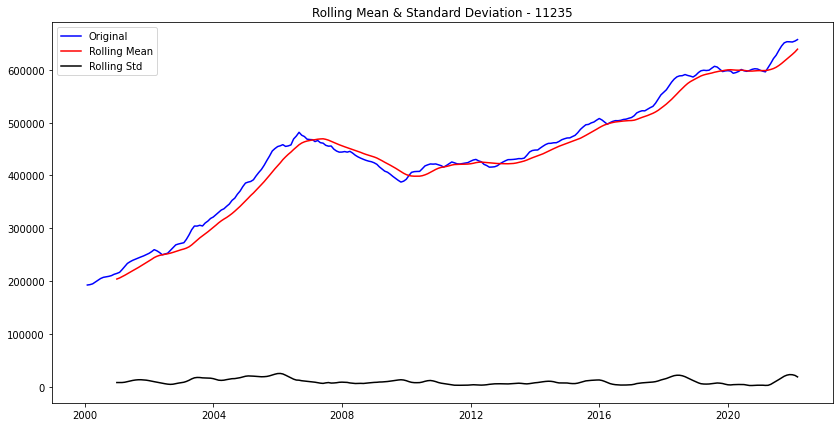

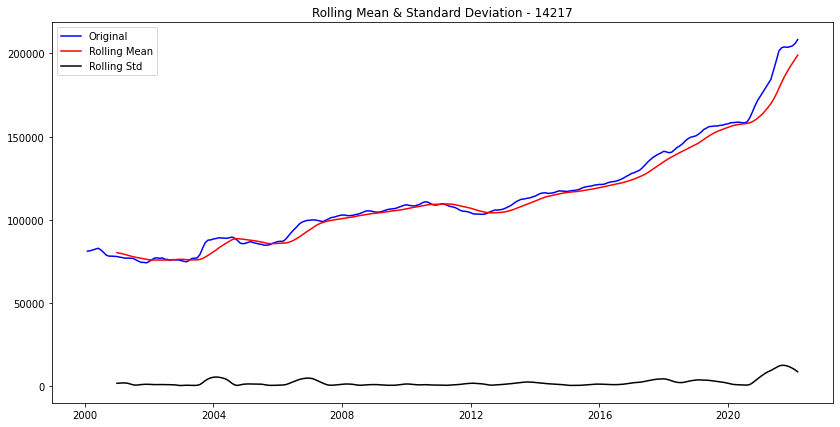

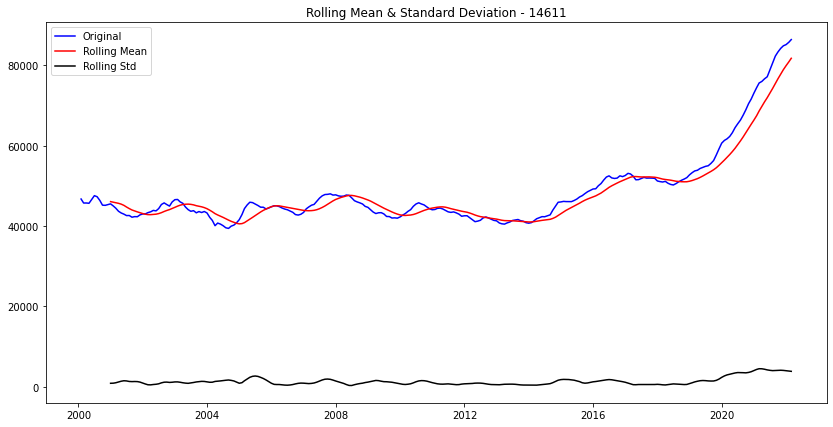

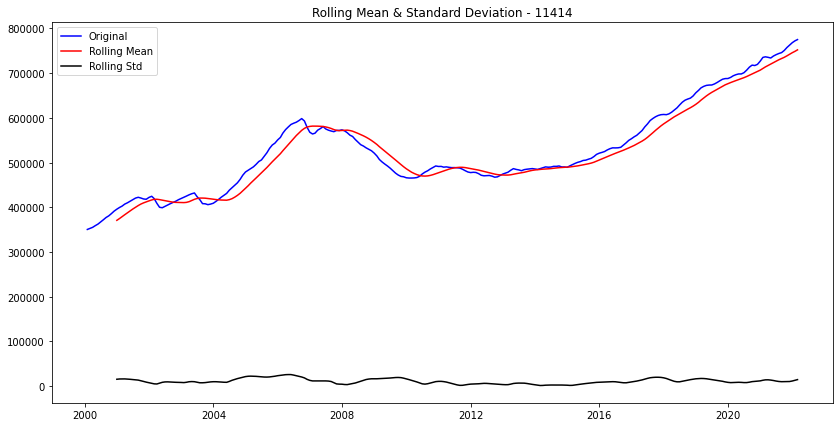

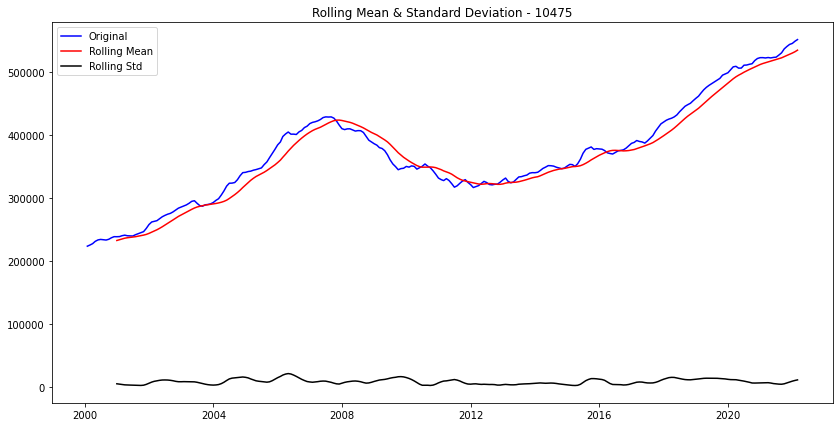

In [33]:
for n in range(len(dfs_ts)):
    stationarity_test(dfs_ts[n])

In [34]:
dfs_ts[0]['RegionName'][0]

11235

In [35]:
for n in range(len(dfs_ts)):
    results = adfuller(dfs_ts[n]['return'].dropna())
    zipcode = dfs_ts[n]['RegionName'][0]
    print('ADFuller test p-value for stationary - ' + str(zipcode))
    print('P-value', results[1])
    if results[1] > 0.05:
          print('Fail to reject the null hypothesis. The data is not stationary. \n')
    else:
          print('Reject the null hypothesis. The data is stationary. \n')

ADFuller test p-value for stationary - 11235
P-value 0.16520739226925324
Fail to reject the null hypothesis. The data is not stationary. 

ADFuller test p-value for stationary - 14217
P-value 0.0016116922597806135
Reject the null hypothesis. The data is stationary. 

ADFuller test p-value for stationary - 14611
P-value 0.012760888184241025
Reject the null hypothesis. The data is stationary. 

ADFuller test p-value for stationary - 11414
P-value 0.03187286732704704
Reject the null hypothesis. The data is stationary. 

ADFuller test p-value for stationary - 10475
P-value 0.3722522232203349
Fail to reject the null hypothesis. The data is not stationary. 



For the five zipcodes:

* The rolling mean shows a trend;
* The Dickey-Fuller test cannot reject the null hypothesis of non-stationarity (p-value > 0.05).

From the results above, two of the five zip codes resulted in non-stationary at a 95 % confidence level. Therefore, these two zipcodes will need the ‘I’ parameter in the ARIMA model is going to be set to 1, but we will look at the aic result for further determination.

## Step 5: ARIMA Modeling and Forecasting

Time series provide the opportunity to predict/forecast future values based on previous values. The specific properties of time series data mean that specialized statistical methods are usually required. One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for AutoregRessive Integrated Moving Average. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

The AR and MA parameters can be estimated using the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots of the stationary time series.

In [36]:
def acf_pacf(df,alags=48,plags=48):
    #Create figure
    fig = plt.figure(figsize=(18,10))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    zipcode = df['RegionName'][0]
    #Make ACF plot
    plot_acf(df['return'],lags=alags, zero=False,ax=ax1)
    #Make PACF plot
    plot_pacf(df['return'],lags=plags, ax=ax2)
    ax1.set_title('Autocorrelation (ACF) - ' + str(zipcode))
    ax2.set_title('Partial Autocorrelation (PACF) - ' + str(zipcode))

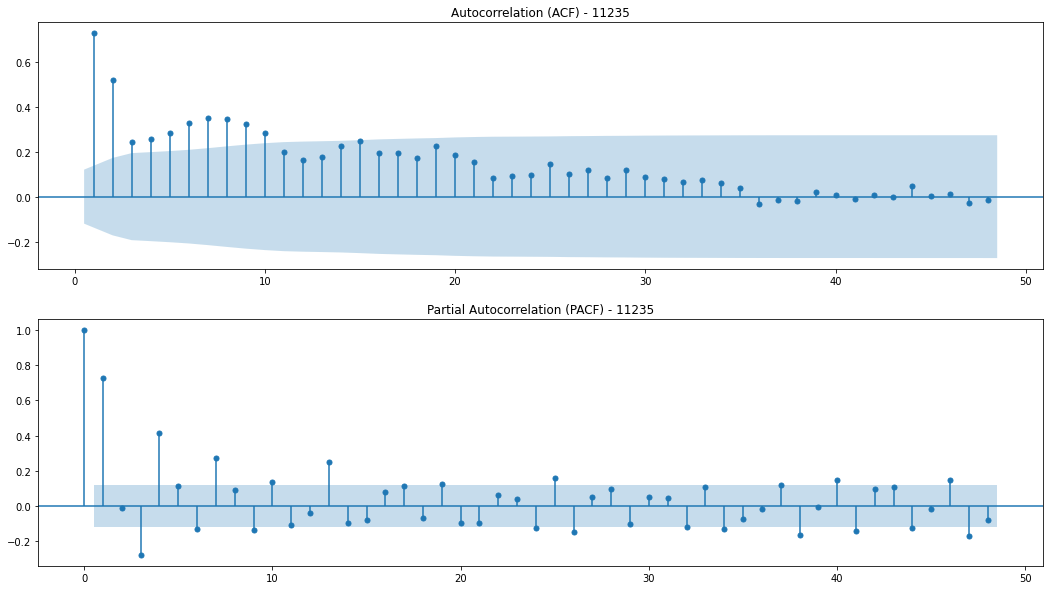

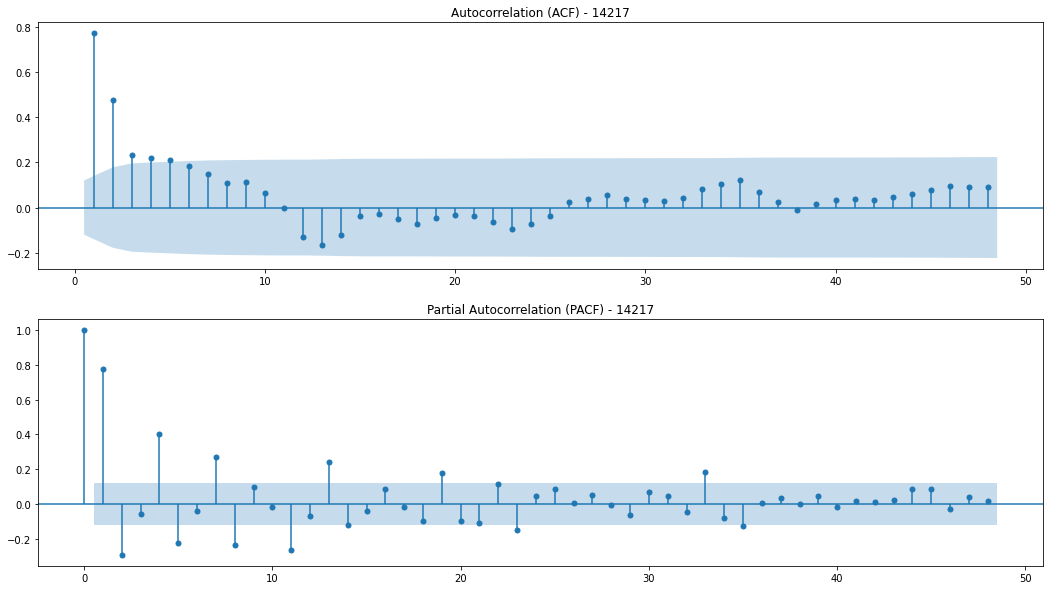

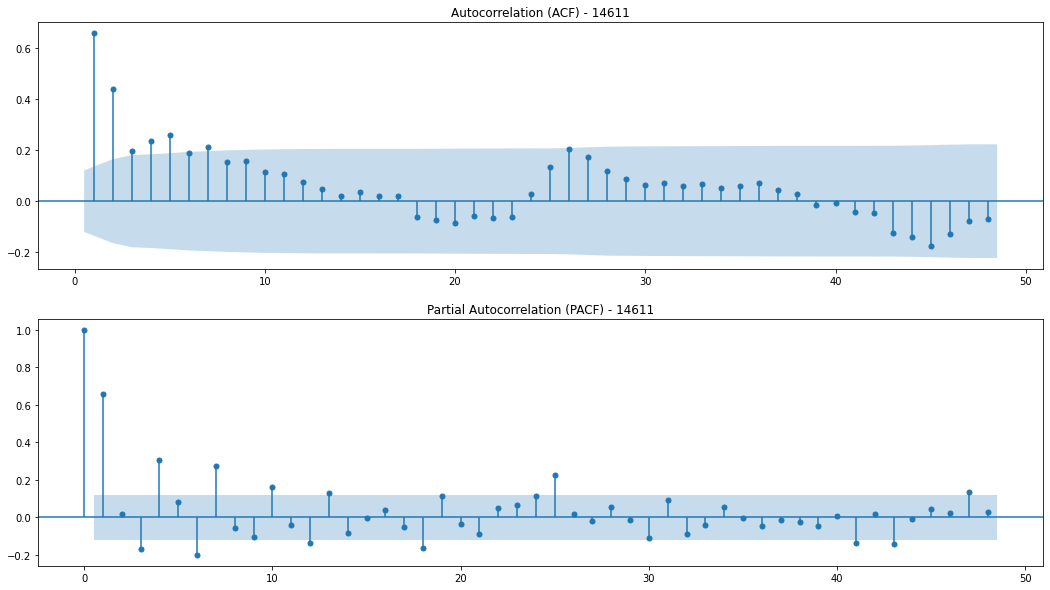

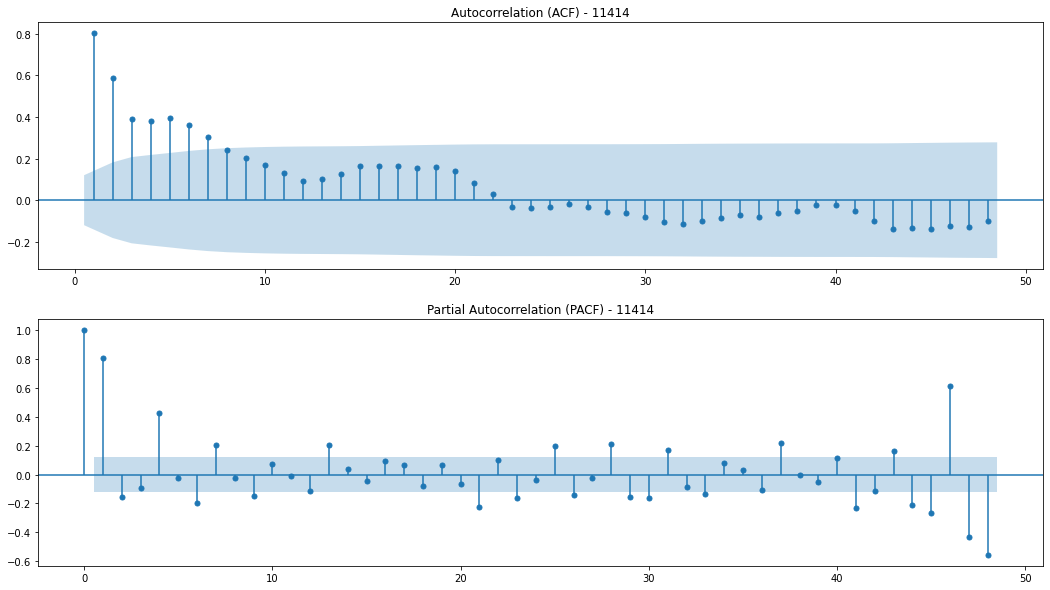

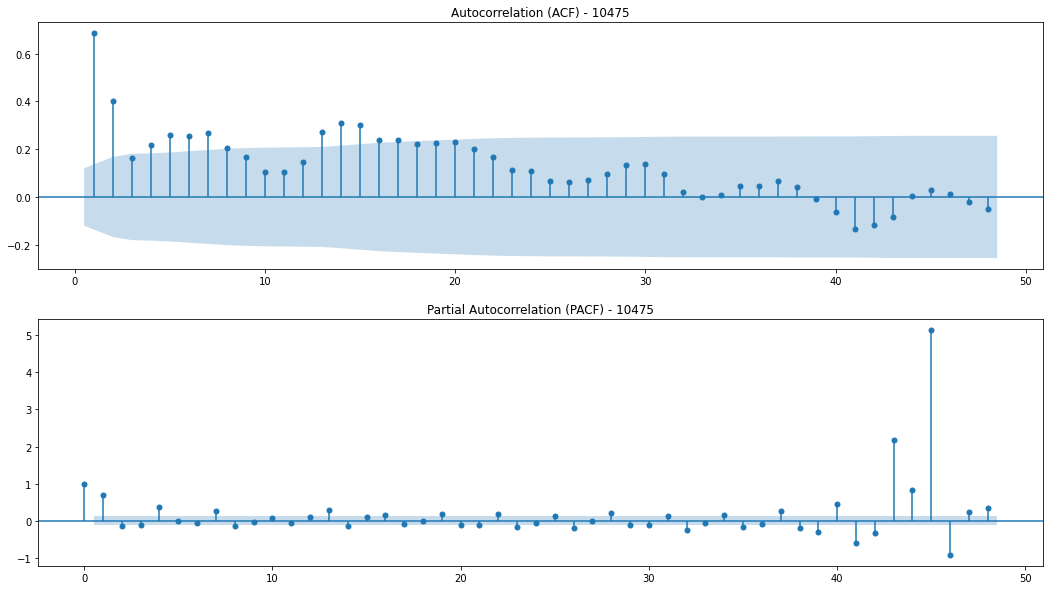

In [37]:
for n in range(len(dfs_ts)):
    acf_pacf(dfs_ts[n], alags=48, plags=48)

### Parameter Selection for the ARIMA Time Series Model 

The predictors depend on the parameters (p,d,q) of the ARIMA model:

* p = number of AR (Auto-Regressive) terms - which allows us to incorporate the effect of past values into our model.
* d = number of differences - which is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation.
* q = number of MA (Moving Average) terms - which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past. MA terms form lagged forecast errors in prediction equation.

These three distinct integer values, (p, d, q), are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:
* (p, d, q) are the non-seasonal parameters described above.
* (p, d, q) follow the same definition but are applied to the seasonal component of the time series.
* The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.). We will not apply it to our model.

The AR and MA parameters can be estimated using the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots of the stationary time series.

In [38]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

### AIC (Akaike Information Criterion) as Regularization Measure

For evaluating the model, we shall use the AIC (Akaike Information Criterion) value, which is provided by ARIMA models fitted using statsmodels library. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value. To achieve this, perform following tasks:
* Initialize an empty list to store results
* Iterate through all the paramaters in pdq with parameters in seasonal pdq (nested loop ) to create a grid
* Run ARIMA from statsmodels for each iteration. Details can be found here. Set enforce_stationarity and enforce_invertibility to False
* Get the results in each iteration with model.fit() and store the AIC values
* Find the lowest AIC and select parameters for further analysis

In [39]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
def best_aic(df):
    
    ans = []
    for comb in pdq:
        try:
            mod = sm.tsa.arima.ARIMA(df['return'],
                                            order=comb,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
        except:
            continue
    
    ans_df = pd.DataFrame(ans, columns=['pdq','aic'])
    output = ans_df.loc[ans_df['aic'].idxmin()]
    
    return output

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [41]:
best_aic(dfs_ts[0])

pdq    (1, 0, 0)
aic     -1952.85
Name: 4, dtype: object

In [42]:
best_aic(dfs_ts[1])

pdq    (1, 0, 1)
aic     -2032.27
Name: 5, dtype: object

In [43]:
best_aic(dfs_ts[2])

pdq    (1, 0, 0)
aic     -1782.63
Name: 4, dtype: object

In [44]:
best_aic(dfs_ts[3])

pdq    (1, 0, 0)
aic     -2093.47
Name: 4, dtype: object

In [45]:
best_aic(dfs_ts[4])

pdq    (1, 0, 0)
aic     -1924.86
Name: 4, dtype: object

### Fitting an ARIMA Time Series Model

In [46]:
def arima_model_fit(df, pdq):
    
    ARIMA_MODEL = sm.tsa.arima.ARIMA(df['return'], 
                                    order = pdq,  
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    print('ARIMA Model Summary - ' + str(df['RegionName'][0]) + '\n')
    print(output.summary().tables[1])
    output.plot_diagnostics(figsize=(15, 18))
    plt.show() 

ARIMA Model Summary - 11235

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.001      3.427      0.001       0.002       0.007
ar.L1          0.7260      0.039     18.402      0.000       0.649       0.803
sigma2      3.605e-05   2.37e-06     15.236      0.000    3.14e-05    4.07e-05


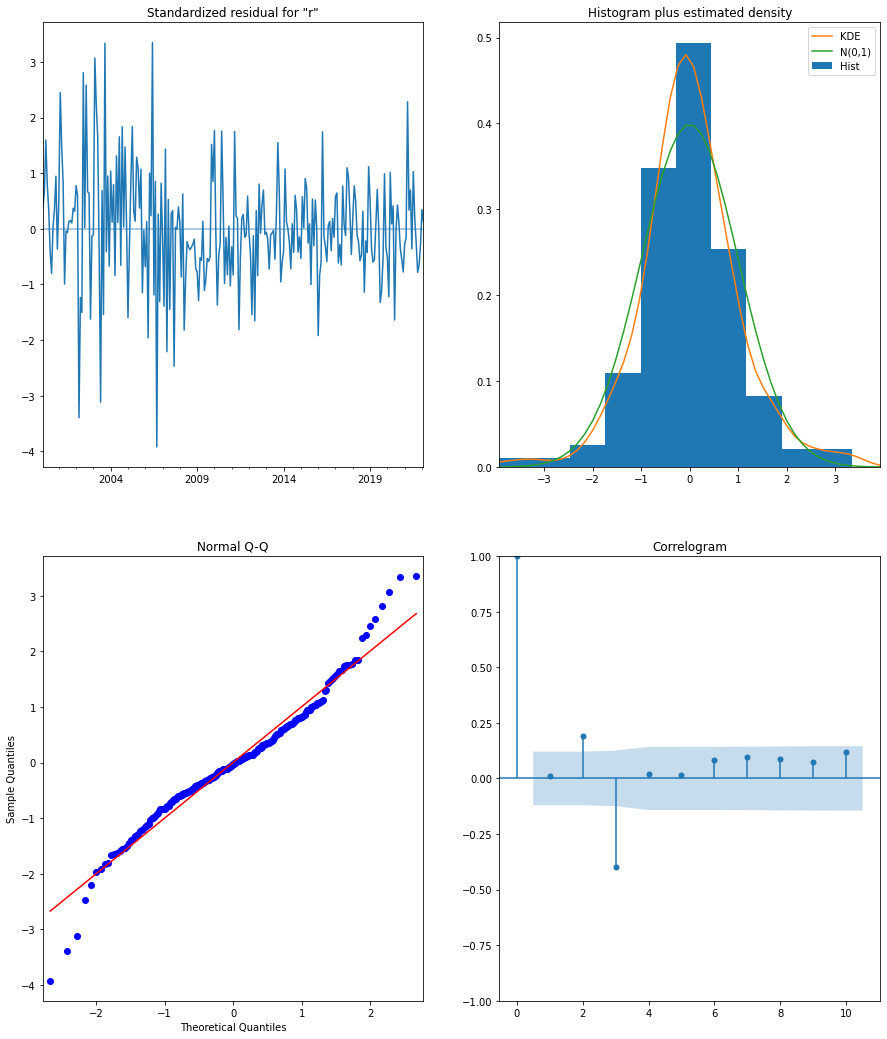

In [47]:
# zipcode 11235: 
arima_model_fit(dfs_ts[0], (1,0,0))

ARIMA Model Summary - 14217

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      2.786      0.005       0.001       0.006
ar.L1          0.6910      0.042     16.460      0.000       0.609       0.773
ma.L1          0.2328      0.055      4.220      0.000       0.125       0.341
sigma2      2.572e-05   1.36e-06     18.894      0.000     2.3e-05    2.84e-05


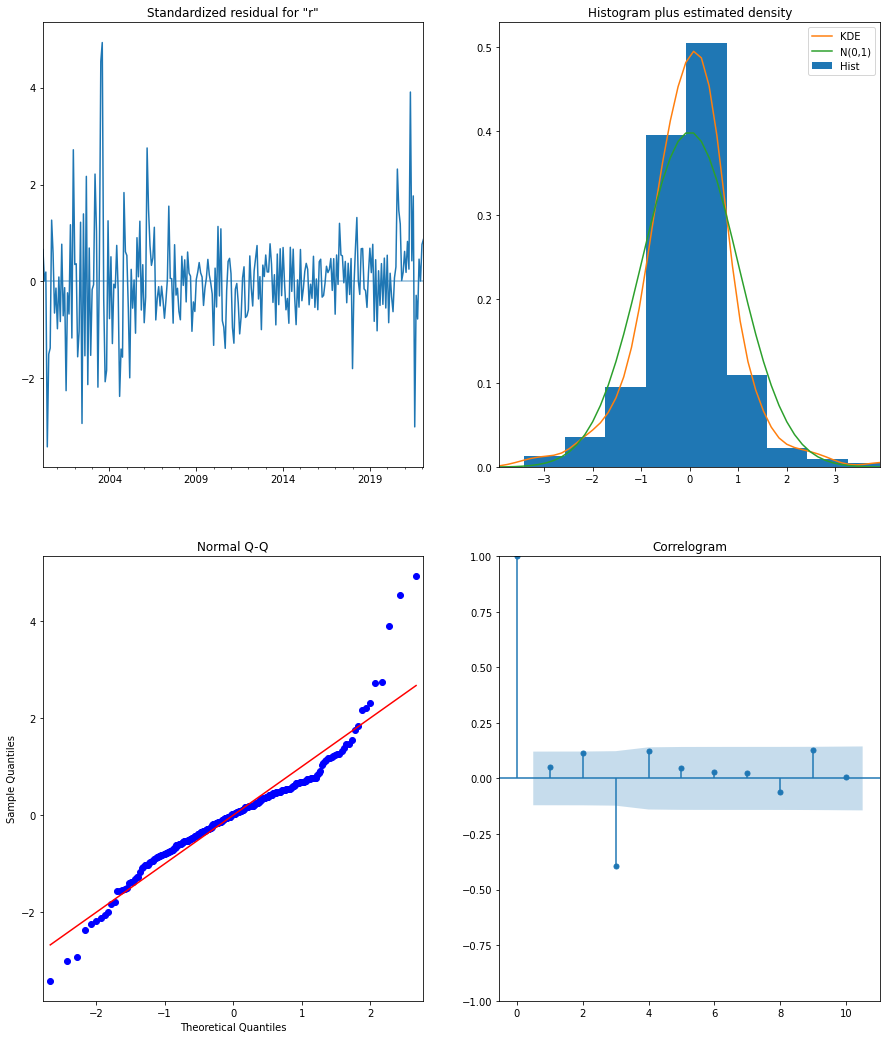

In [48]:
# zipcode 14217
arima_model_fit(dfs_ts[1], (1,0,1))

ARIMA Model Summary - 14611

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.595      0.111      -0.001       0.005
ar.L1          0.6561      0.040     16.365      0.000       0.578       0.735
sigma2      6.851e-05   5.08e-06     13.495      0.000    5.86e-05    7.85e-05


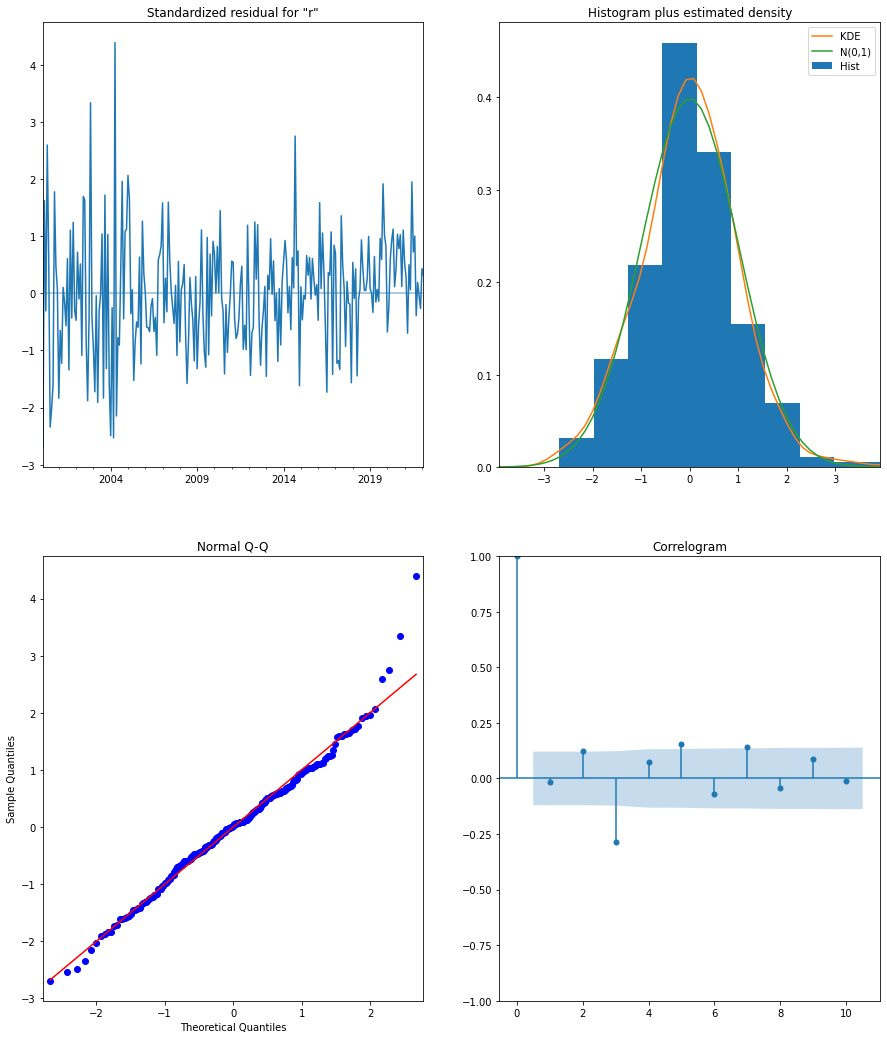

In [49]:
# zipcode 14611
arima_model_fit(dfs_ts[2], (1,0,0))

ARIMA Model Summary - 11414

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.002      1.815      0.069      -0.000       0.006
ar.L1          0.8014      0.031     26.095      0.000       0.741       0.862
sigma2      2.122e-05   1.14e-06     18.592      0.000     1.9e-05    2.35e-05


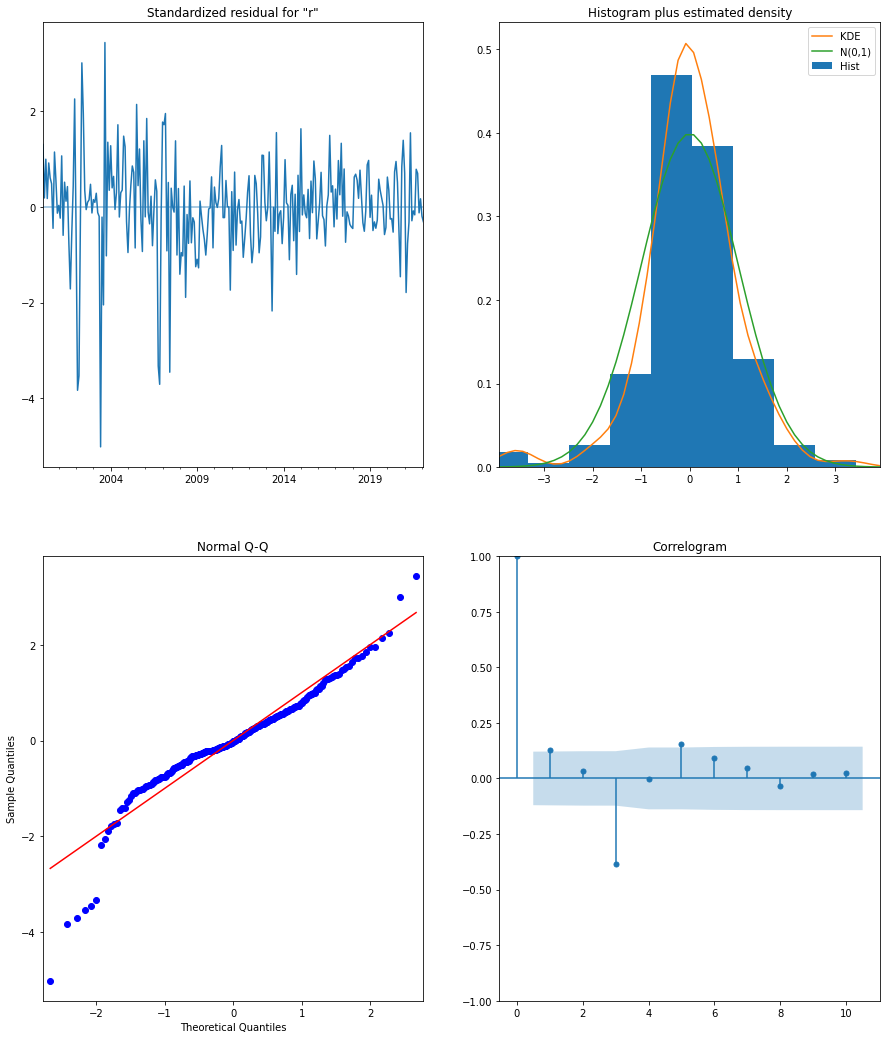

In [50]:
# zipcode 11414
arima_model_fit(dfs_ts[3], (1,0,0))

ARIMA Model Summary - 10475

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      2.728      0.006       0.001       0.006
ar.L1          0.6845      0.041     16.555      0.000       0.603       0.766
sigma2          4e-05   3.08e-06     12.974      0.000     3.4e-05     4.6e-05


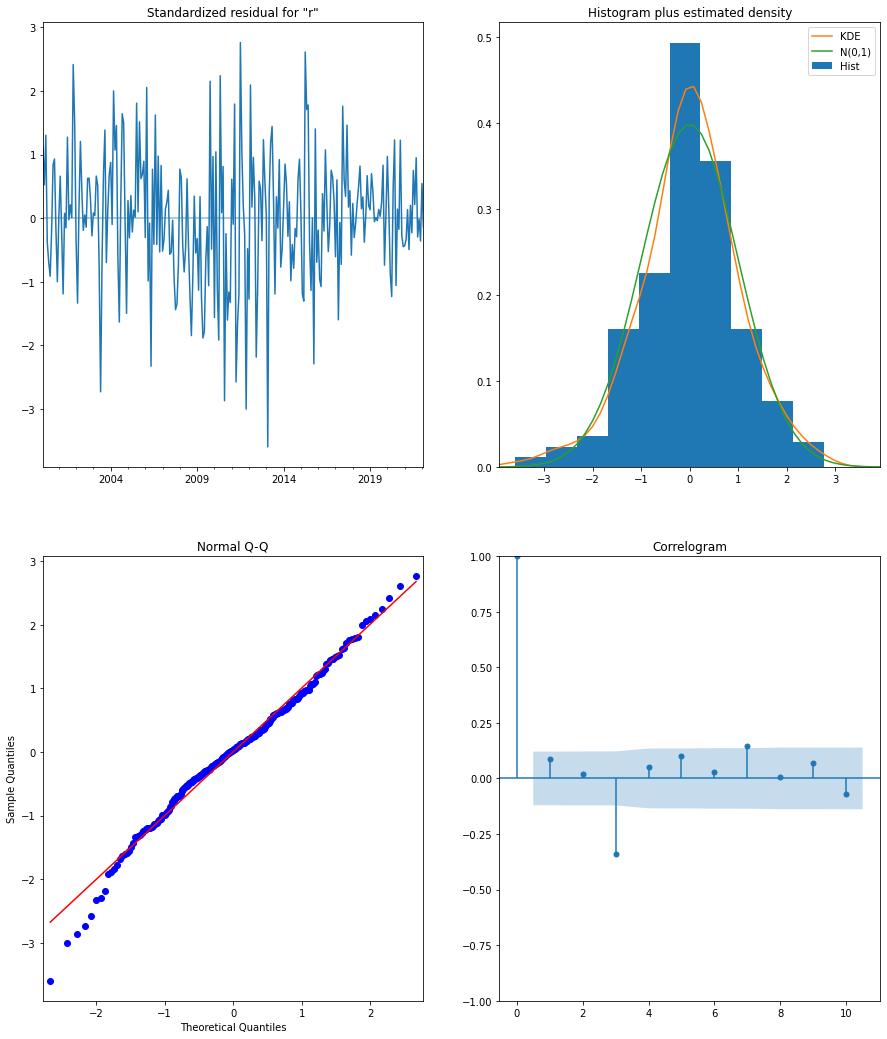

In [51]:
# zipcode 10475
arima_model_fit(dfs_ts[4], (1,0,0))

The purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

Let's check for these assumptions from diagnostics plots.

* In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself. There is no pattern in the autocorrelations (i.e. no consistent upward or downward pattern as you travel across the x-axis). This set of data likely has no significant autocorrelation.

These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

### Validating the Models

#### One-step Ahead Forecasting

The forecasts align with the true values as seen above, with overall increase trend. We shall also check for the accuracy of our forecasts using MSE (Mean Squared Error). This will provide us with the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [52]:
def arima_model_one_step_forecast(df, pdq):
    
    ARIMA_MODEL = sm.tsa.arima.ARIMA(df['return'], 
                                     order = pdq,  
                                     enforce_stationarity=False, 
                                     enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()
    
    pred = output.get_prediction(start=pd.to_datetime('2019-01-31'), dynamic=False)
    pred_conf = pred.conf_int()
    
    # Plot real vs predicted values along with confidence interval

    rcParams['figure.figsize'] = 18, 6

    # Plot observed values
    ax = df['return']['2009-07-31':].plot(label='observed')

    # Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=0.5)

    # Set axes labels
    ax.set_xlabel('Year')
    ax.set_ylabel('Monthly Return of Typical Home Value')
    ax.set_title('ARIMA Model One-Step Ahead Forecast - ' + str(df['RegionName'][0]))
    plt.legend()
    plt.show()
    
    # Get the real and predicted values
    return_forecasted = pred.predicted_mean
    return_truth = df['return']['2016-01-31':]

    # Compute the mean square error
    mse = ((return_forecasted - return_truth) ** 2).mean()
    print('The Mean Squared Error of our one-step ahead forecasts is {}'.format(round(mse, 4)))

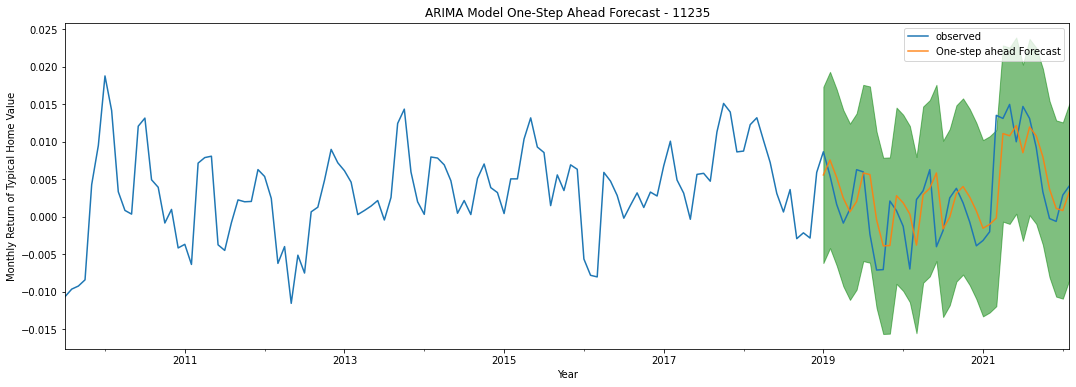

The Mean Squared Error of our one-step ahead forecasts is 0.0


In [53]:
arima_model_one_step_forecast(dfs_ts[0], (1,0,0))

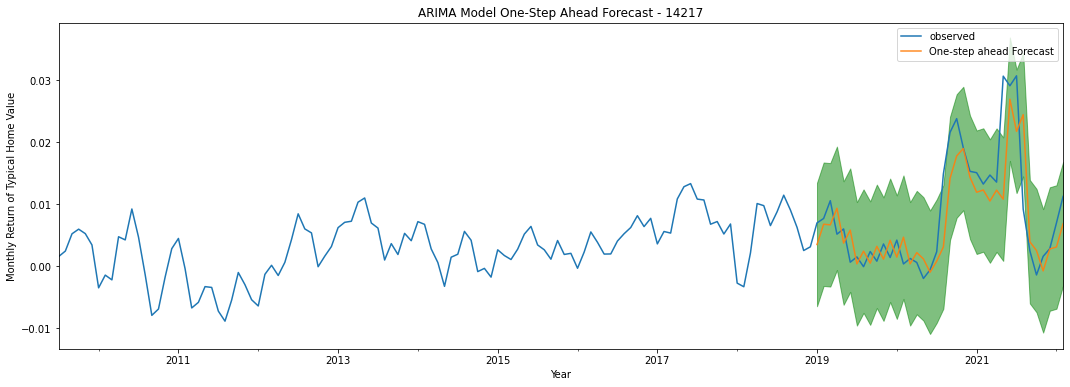

The Mean Squared Error of our one-step ahead forecasts is 0.0


In [54]:
arima_model_one_step_forecast(dfs_ts[1], (1,0,1))

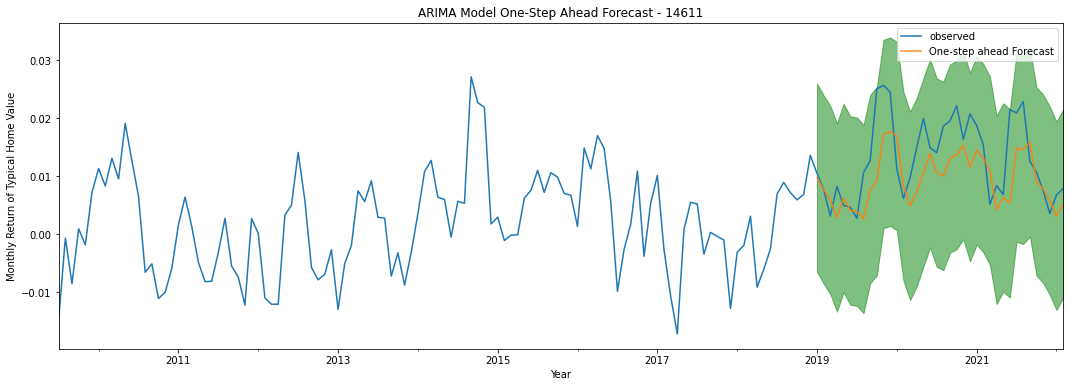

The Mean Squared Error of our one-step ahead forecasts is 0.0


In [55]:
arima_model_one_step_forecast(dfs_ts[2], (1,0,0))

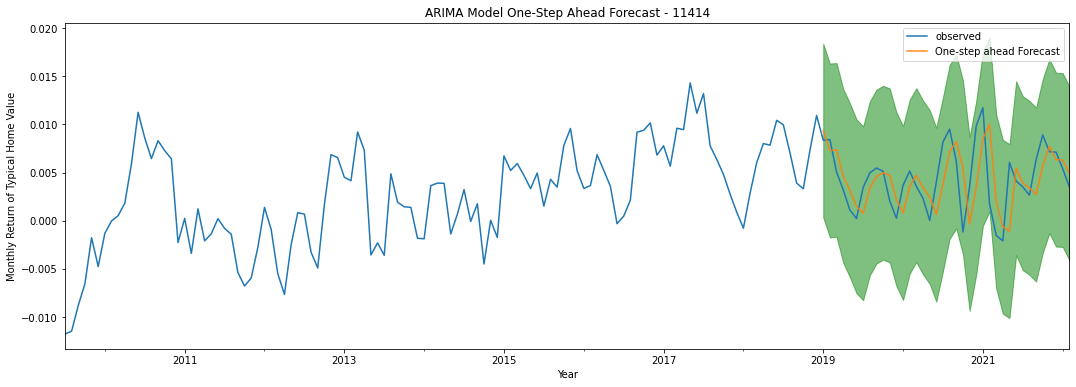

The Mean Squared Error of our one-step ahead forecasts is 0.0


In [56]:
arima_model_one_step_forecast(dfs_ts[3], (1,0,0))

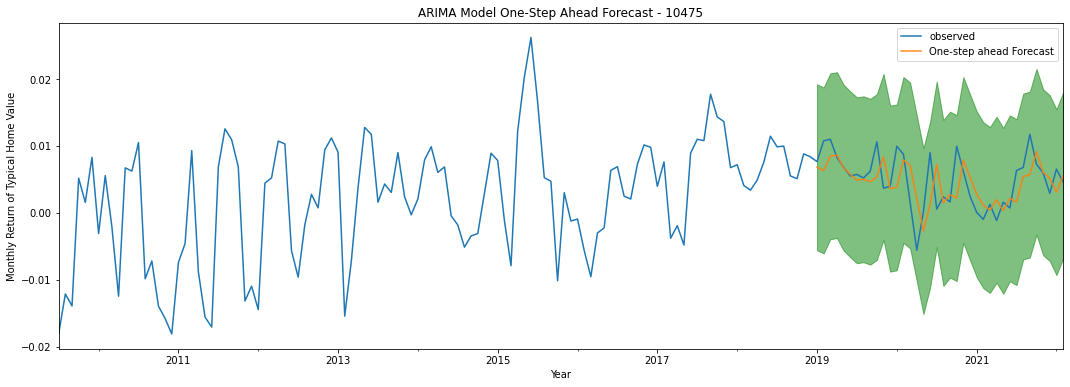

The Mean Squared Error of our one-step ahead forecasts is 0.0


In [57]:
arima_model_one_step_forecast(dfs_ts[4], (1,0,0))

For the five selected zipcodes, their MSE of our one-step ahead forecasting is close to 0, which indicates that the estimator is predicting observations of the parameter with perfect accuracy.

### Dynamic Forecasting

In [58]:
def arima_model_dynamic_forecast(df, pdq):
    
    ARIMA_MODEL = sm.tsa.arima.ARIMA(df['return'], 
                                     order = pdq, 
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()
    
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2019-01-31'), 
                                         dynamic=True,
                                         full_results=True)
    
    pred_dynamic_conf = pred_dynamic.conf_int()
    
    # Plot real vs predicted values along with confidence interval

    rcParams['figure.figsize'] = 18, 6

    # Plot observed values
    ax = df['return']['2009-07-31':].plot(label='observed')

    # Plot predicted values
    pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

    # Plot the range for confidence intervals
    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], 
                    color='g',
                    alpha=0.25,
                    label='Conf Interval')

    # Set axes labels
    ax.set_xlabel('Year')
    ax.set_ylabel('Monthly Return of Typical Home Value')
    ax.set_title('ARIMA Model Dynamic Forecast - ' + str(df['RegionName'][0]))
    plt.legend()
    plt.show()
    
    # Get the real and predicted values
    return_forecasted = pred_dynamic.predicted_mean
    return_truth = df['return']['2016-01-31':]

    # Compute the mean square error
    mse = ((return_forecasted - return_truth) ** 2).mean()
    print('The Mean Squared Error of our dynamic forecasts is {}'.format(round(mse, 4)))

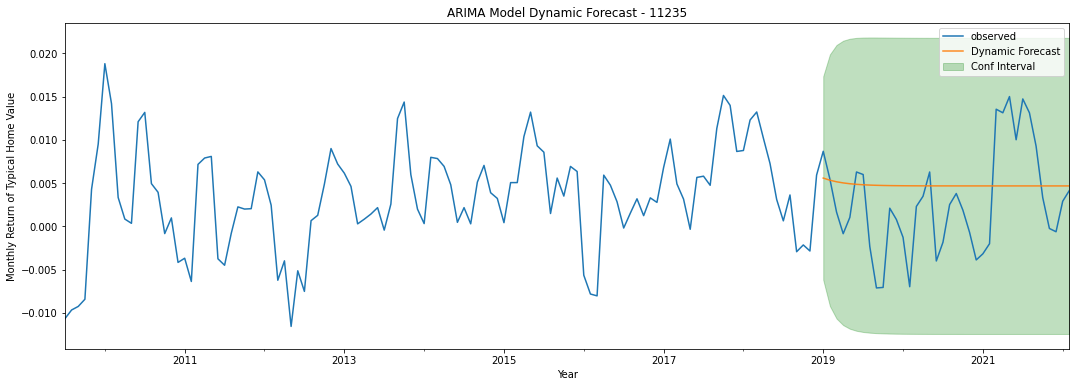

The Mean Squared Error of our dynamic forecasts is 0.0


In [59]:
arima_model_dynamic_forecast(dfs_ts[0], (1,0,0))

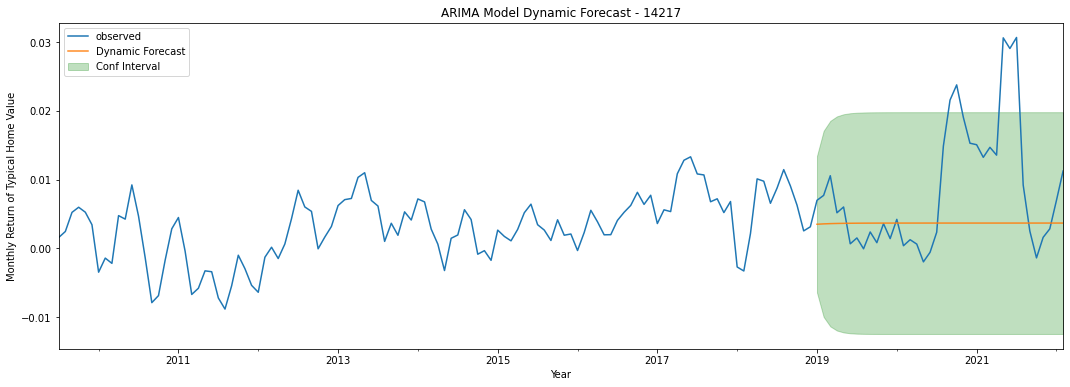

The Mean Squared Error of our dynamic forecasts is 0.0001


In [60]:
arima_model_dynamic_forecast(dfs_ts[1], (1,0,1))

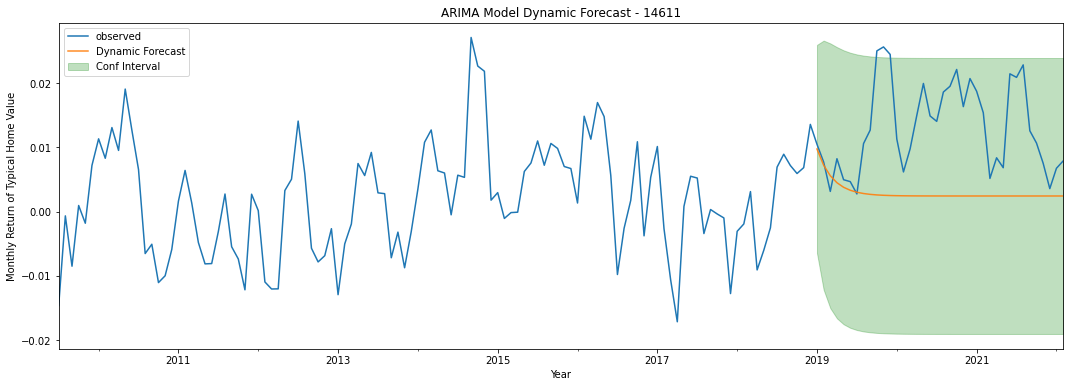

The Mean Squared Error of our dynamic forecasts is 0.0002


In [61]:
arima_model_dynamic_forecast(dfs_ts[2], (1,0,0))

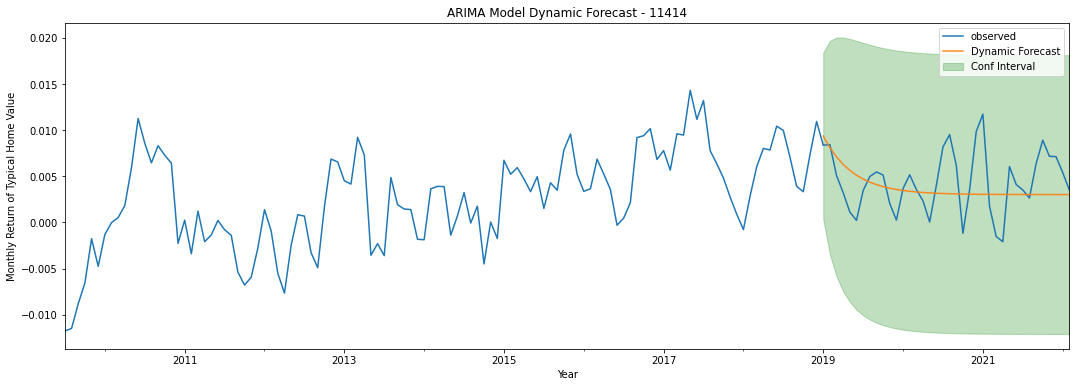

The Mean Squared Error of our dynamic forecasts is 0.0


In [62]:
arima_model_dynamic_forecast(dfs_ts[3], (1,0,0))

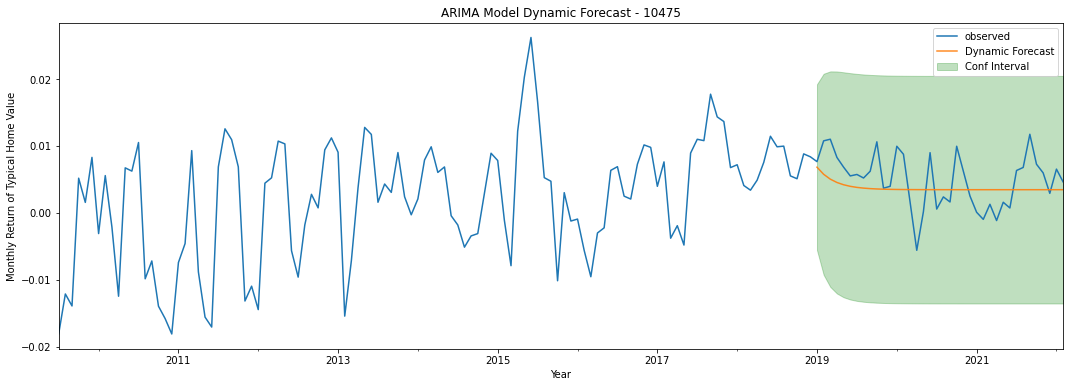

The Mean Squared Error of our dynamic forecasts is 0.0


In [63]:
arima_model_dynamic_forecast(dfs_ts[4], (1,0,0))

### Producing and Visualizing Forecasts

Now we are leveraging our ARIMA time series model to forecast future values. The .get_forecast() method of our time series output can compute forecasted values for a specified number of steps ahead.

In [64]:
def arima_model_forecast(df, pdq):
    
    ARIMA_MODEL = sm.tsa.arima.ARIMA(df['return'], 
                                     order = pdq,
                                     enforce_stationarity=False, 
                                     enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()
    
    # Get forecast 120 steps ahead in future
    prediction = output.get_forecast(steps = 120)

    # Get confidence intervals of forecasts
    pred_conf = prediction.conf_int()
    
    # Plot future predictions with confidence intervals
    ax = df['return'].plot(label='observed', figsize=(20, 15))
    
    prediction.predicted_mean.plot(ax=ax, label='Forecast')
    
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=0.05)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Monthly Return of Typical Home Value')
    ax.set_title('ARIMA Model Forecast - ' + str(df['RegionName'][0]))
    
    plt.legend()
    plt.show()
    
    year_1 = (1+prediction.predicted_mean[:12]).prod()-1
    year_3 = (1+prediction.predicted_mean[:36]).prod()-1
    year_5 = (1+prediction.predicted_mean[:60]).prod()-1
    year_10 = (1+prediction.predicted_mean).prod()-1
    
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    
    summary_return = [df['RegionName'][0], year_1, year_3, year_5, year_10]
    
    return summary_return
    

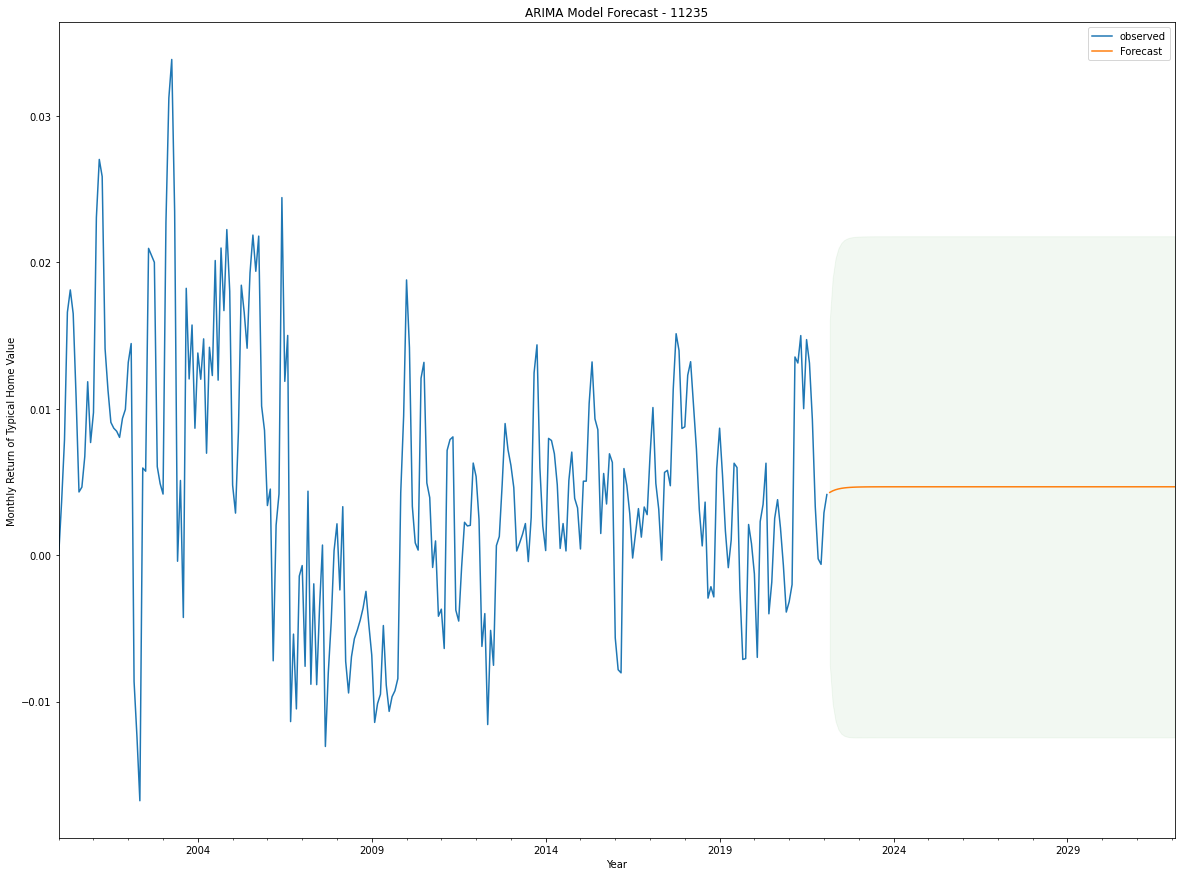

Total expected return in 1 year: 5.6%
Total expected return in 3 years: 18.09%
Total expected return in 5 year: 32.05%
Total expected return in 10 years: 74.63%


In [65]:
list0 = arima_model_forecast(dfs_ts[0], (1, 0, 0))

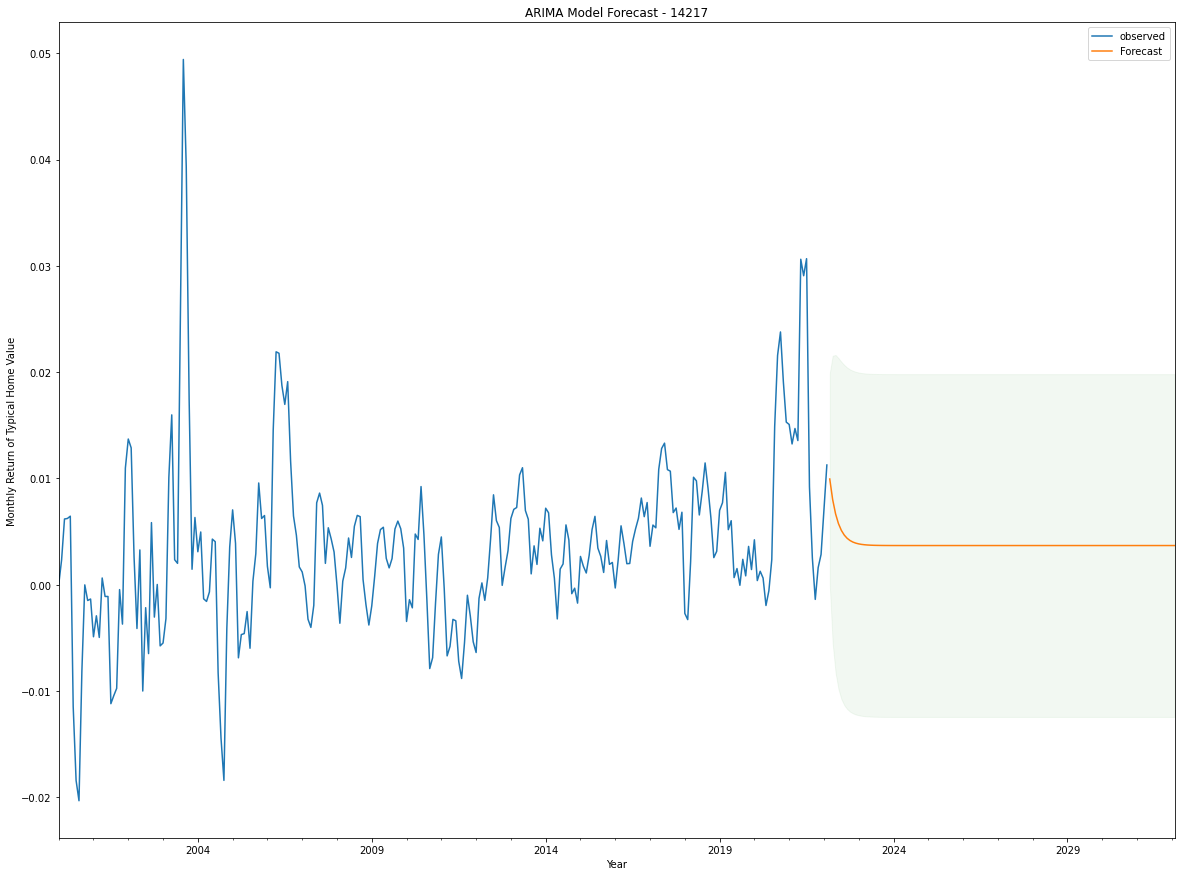

Total expected return in 1 year: 6.62%
Total expected return in 3 years: 16.5%
Total expected return in 5 year: 27.26%
Total expected return in 10 years: 58.72%


In [66]:
list1 = arima_model_forecast(dfs_ts[1], (1, 0, 1))

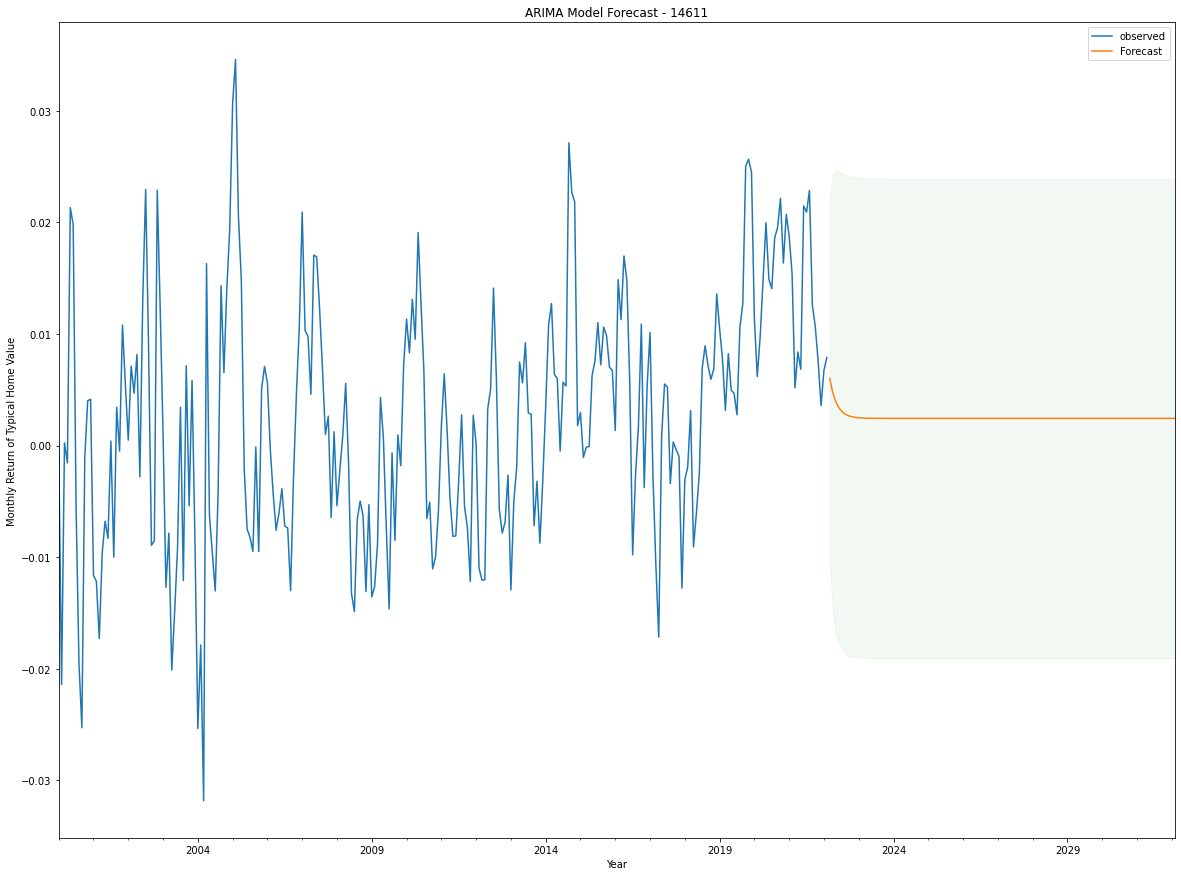

Total expected return in 1 year: 4.03%
Total expected return in 3 years: 10.29%
Total expected return in 5 year: 16.92%
Total expected return in 10 years: 35.3%


In [67]:
list2 = arima_model_forecast(dfs_ts[2], (1, 0, 0))

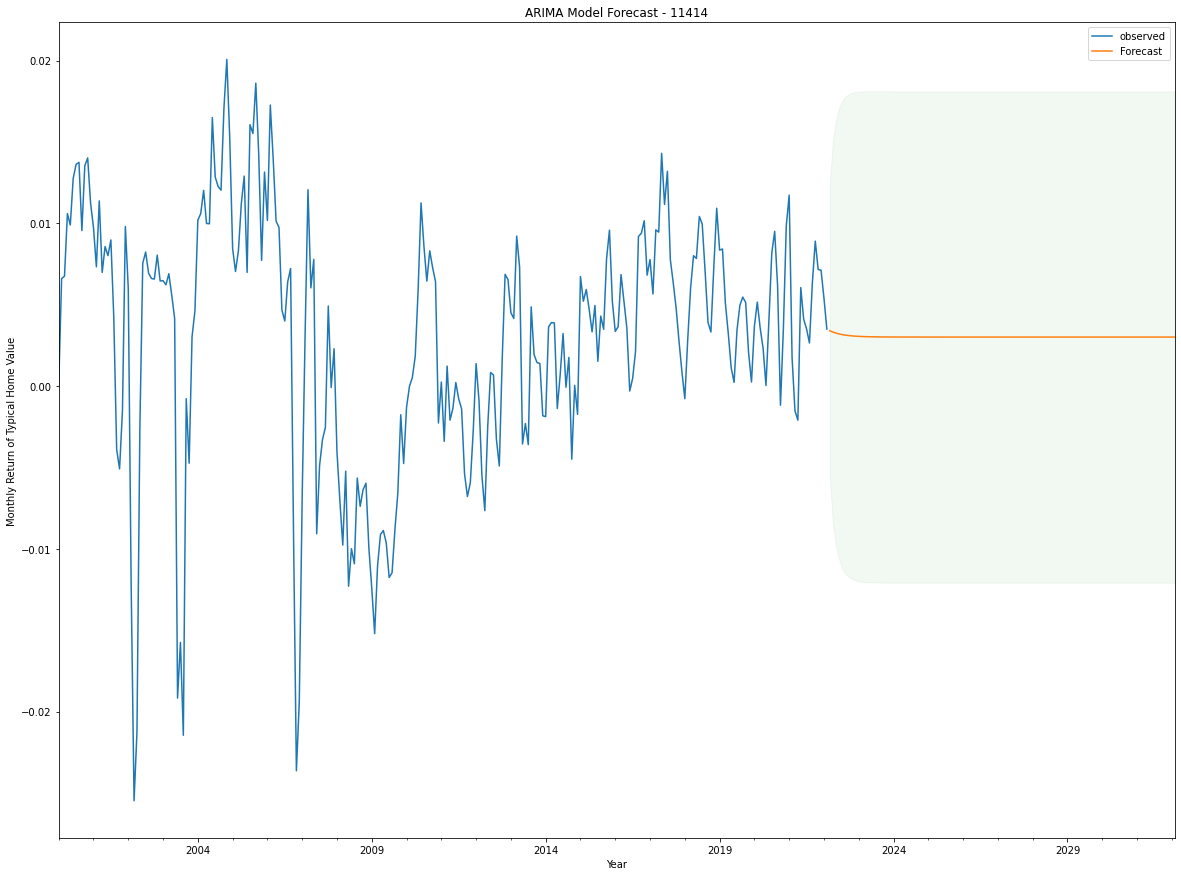

Total expected return in 1 year: 3.87%
Total expected return in 3 years: 11.68%
Total expected return in 5 year: 20.06%
Total expected return in 10 years: 43.85%


In [68]:
list3 = arima_model_forecast(dfs_ts[3], (1, 0, 0))

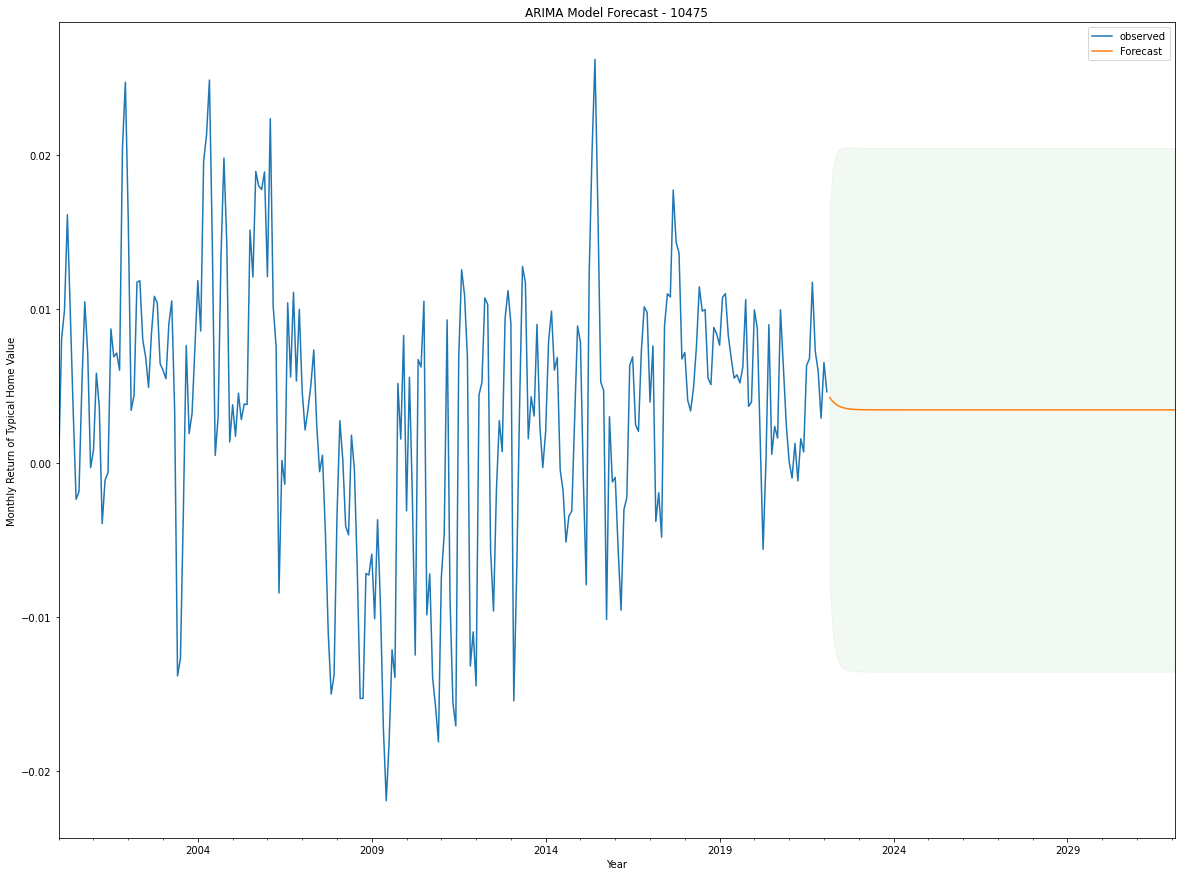

Total expected return in 1 year: 4.49%
Total expected return in 3 years: 13.51%
Total expected return in 5 year: 23.31%
Total expected return in 10 years: 51.67%


In [69]:
list4 = arima_model_forecast(dfs_ts[4], (1, 0, 0))

In [70]:
summary_df = pd.DataFrame(list(zip(list0, list1, list2, list3, list4))).T
summary_df.columns = ['Zipcode', '1-Yr ROI%', '3-Yr ROI%', '5-Yr ROI%', '10-Yr ROI%']
summary_df['Zipcode'] = summary_df['Zipcode'].astype(int)
summary_df.set_index('Zipcode', inplace=True)

In [71]:
summary_df = summary_df.apply(lambda x: round(x*100, 2))
summary_df.sort_values(by='3-Yr ROI%', ascending=False)

,1-Yr ROI%,3-Yr ROI%,5-Yr ROI%,10-Yr ROI%
Zipcode,,,,
11235,5.60,18.09,32.05,74.63
14217,6.62,16.50,27.26,58.72
10475,4.49,13.51,23.31,51.67
11414,3.87,11.68,20.06,43.85
14611,4.03,10.29,16.92,35.30


## Summary and Next Steps

Based on the five criteria (State, Typical Home Value, Urbanization, Total Growth Rate and Diversification) of investing in real-estate market, we selected 5 zipcodes in New York State with the highest growth rate between year 2009 and 2020 (which excluding the financial crisis and pandemic, these two large events). Upon the selection, we performed a Time Series modeling with ARIMA to predict the future ROI. 

We summarized our findings below:

* Zipcode 11235, Brooklyn NY - 18.1% ROI in 3 years
* Zipcode 14217, Kenmore NY - 16.5% ROI in 3 years
* Zipcode 10475, Bronx NY - 13.5% ROI in 3 years
* Zipcode 11414, Queens NY - 11.7% ROI in 3 years
* Zipcode 14611, Rochester NY - 10.3% ROI in 3 years

Three of the five are in New York City. 

Forecasts are solely based on historic monthly returns, and past performance does not necessarily predict future results. We excluded the financial crisis and pandemic when we conducted the preliminary selection. However, when our client start the investment, it will be at the time period of post-pandemic. The typical home value in these areas will be changed. 

Therefore, as next steps, we need to take into account of other external factors to improve the models and ultimately the quality of the forecasts.

The factors to be further taken into consideration are:

* historic event: financial crisis / pandemic
* macro-economics: interest rate (mortgage rate, our client will apply leverage to their investment)
* house market safety score: given the hate crime is severe in the New York City, the safety will be a key concern when people buy the houses.